In [ ]:
import sys
sys.path.append('/Users/evatakou/noise_est')
import stim
import numpy as np
import pymatching
from pymatching import Matching
from circuit_SC_phen import *

In [2]:
from sims.surface_code_bare_ancilla.construct_dem import get_measurement_data,project_data_meas,get_initial_state,surface_code_DEM, get_defects
from sims.surface_code_bare_ancilla.estimation_funcs_surface_code import *
from utilities.general_utils import avg_vi,avg_vivj
from utilities.utils_for_decoding import decode_both_dems_same_data


In [ ]:
def get_DEM(distance,num_rounds,num_shots,p_data,p_anc,std):

    num_ancilla   = distance*(distance-1)
    
    circuit       = planar_surface_code_circuit_X_memory(distance,num_rounds,p_data,p_anc,std)

    defects_matrix,data_qubit_meas = get_defects(circuit,distance,num_shots,num_rounds)
    vi_mean                        = avg_vi(defects_matrix)
    pij_time    = estimate_time_edge_probs(num_rounds,num_ancilla,defects_matrix,vi_mean)
    

    pij_bulk,pij_bd = estimate_bulk_and_bd_edge_probs(num_rounds,num_ancilla,distance,defects_matrix,pij_time,vi_mean)

    
    my_DEM = surface_code_DEM(pij_bulk,pij_bd,pij_time,circuit.detector_error_model(flatten_loops=True))

    return my_DEM,circuit

std=0
distance   = 9
num_rounds = 9
num_shots  = 10**6
p_data     = 0.1
p_anc      = 0.2



In [ ]:
def decode_both_dems_same_data(reconstructed_DEM:stim.DetectorErrorModel,circuit:stim.Circuit, detector_error_model: stim.DetectorErrorModel ,num_shots:int):
    '''
    Decode stim's DEM obtained from a circuit and a reconstructed DEM using MWPM, and on the same data.

    Inputs: 
        my_DEM:    Reconstructed detector error model
        circuit:   The true stim circuit (w/ variations on data/ancilla qubits)
        detector_error_model: stim's detector error model for the case of all error rates of data being equal to p, and all error rates of ancilla being equal to q
        num_shots: # of shots to use to decode
    Output:
        num_errors_est:    Total # of logical errors obtained by decoding the reconstructed DEM
        num_errors_stim:   Total # of logical errors obtained by decoding stim's DEM
    '''
    # Sample the circuit.
    sampler = circuit.compile_detector_sampler()
    detection_events, observable_flips = sampler.sample(num_shots, separate_observables=True)

    # Configure a decoder using the circuit.
    matcher              = pymatching.Matching.from_detector_error_model(detector_error_model)

    # Run the decoder.
    predictions = matcher.decode_batch(detection_events)

    # Count the mistakes.
    num_errors_stim =   np.sum(~np.all(observable_flips == predictions, axis=1))  

    #Now do the same for my model.

    matcher     = pymatching.Matching.from_detector_error_model(reconstructed_DEM)
    predictions = matcher.decode_batch(detection_events) #use same detection events

    num_errors_est =   np.sum(~np.all(observable_flips == predictions, axis=1))  

    return num_errors_est,num_errors_stim


In [6]:
import numpy as np
from joblib import Parallel, delayed

def get_logical_error_per_p_and_q(std_in, distance, num_shots, num_vals, n_jobs=-1):
    
    prange_data = np.linspace(5e-2, 0.13, num_vals)
    prange_ancilla = np.linspace(5e-2, 0.13, num_vals)

    # prange_data    = np.linspace(1e-2,0.1,num_vals) #(Values used for d=5 in appendix)
    # prange_ancilla = np.linspace(1e-2,0.1,num_vals)
    num_rounds = distance
    

    def evaluate_pair(p, q):
        my_DEM, circuit_true = get_DEM(distance, num_rounds, num_shots, p, q, std_in)
        circuit2 = planar_surface_code_circuit_X_memory(distance, num_rounds, p, q, std=0)
        stims_DEM = circuit2.detector_error_model(flatten_loops=True)
        num_errors_my_DEM, num_errors_stim = decode_both_dems_same_data(my_DEM, circuit_true, stims_DEM, num_shots)

        print(f"p={p:.3f}, q={q:.3f} -> stim: {num_errors_stim / num_shots:.4f}, our_DEM: {num_errors_my_DEM / num_shots:.4f}")

        return num_errors_my_DEM / num_shots, num_errors_stim / num_shots

    all_LE_mine = []
    all_LE_stim = []

    for p in prange_data:
        results = Parallel(n_jobs=n_jobs)(
            delayed(evaluate_pair)(p, q) for q in prange_ancilla
        )

        LE_mine_row, LE_stim_row = zip(*results)
        all_LE_mine.append(LE_mine_row)
        all_LE_stim.append(LE_stim_row)

    return all_LE_mine, all_LE_stim, prange_data, prange_ancilla


distance                                           = 3
std                                                = 5*10**(-3)
num_shots                                          = 5*10**6
num_vals                                           = 15
all_LE_mine,all_LE_stim,prange_data,prange_ancilla = get_logical_error_per_p_and_q(std,distance,num_shots,num_vals)


p=0.050, q=0.050 -> stim: 0.1101, our_DEM: 0.0968
p=0.050, q=0.056 -> stim: 0.1029, our_DEM: 0.0972
p=0.050, q=0.061 -> stim: 0.1034, our_DEM: 0.0968
p=0.050, q=0.067 -> stim: 0.1042, our_DEM: 0.0978
p=0.050, q=0.090 -> stim: 0.1073, our_DEM: 0.1020
p=0.050, q=0.079 -> stim: 0.1060, our_DEM: 0.1002
p=0.050, q=0.073 -> stim: 0.1051, our_DEM: 0.0990
p=0.050, q=0.084 -> stim: 0.1069, our_DEM: 0.1013
p=0.050, q=0.096 -> stim: 0.1086, our_DEM: 0.1028
p=0.050, q=0.101 -> stim: 0.1097, our_DEM: 0.1040
p=0.050, q=0.107 -> stim: 0.1104, our_DEM: 0.1050
p=0.050, q=0.113 -> stim: 0.1112, our_DEM: 0.1059
p=0.050, q=0.119 -> stim: 0.1119, our_DEM: 0.1068
p=0.050, q=0.124 -> stim: 0.1133, our_DEM: 0.1078
p=0.050, q=0.130 -> stim: 0.1137, our_DEM: 0.1090
p=0.056, q=0.050 -> stim: 0.1281, our_DEM: 0.1132
p=0.056, q=0.056 -> stim: 0.1309, our_DEM: 0.1151
p=0.056, q=0.061 -> stim: 0.1214, our_DEM: 0.1150
p=0.056, q=0.067 -> stim: 0.1226, our_DEM: 0.1150
p=0.056, q=0.073 -> stim: 0.1231, our_DEM: 0.1161


In [ ]:
#To store the data:

# with open("stims_for_5_10_minus_3_and_N_5_10_6_d_5_r_5.txt", "w") as file:
#     file.write(str(all_LE_stim))
# with open("mine_for_5_10_minus_3_and_N_5_10_6_d_5_r_5.txt", "w") as file:
#     file.write(str(all_LE_mine))

In [7]:
improvement_factor = []

 
for k in range(len(prange_data)):
    
    temp1 = all_LE_mine[k]
    temp2 = all_LE_stim[k]
    temp  = []

    for l in range(len(prange_ancilla)):

        # temp.append( abs(temp1[l]-temp2[l])/temp2[l]*100 )  #(xf-x)/x %
        temp.append(temp2[l]/temp1[l]) 

        if temp2[l]<temp1[l]:
            print("stim performs better for (p,q) =",(prange_data[k],prange_ancilla[l]))
            print("stim:",temp2[l],"ours:",temp1[l])
            

    improvement_factor.append(temp)

print(max(max(improvement_factor)))

1.1378285482800885


Text(0, 0.5, '$q$')

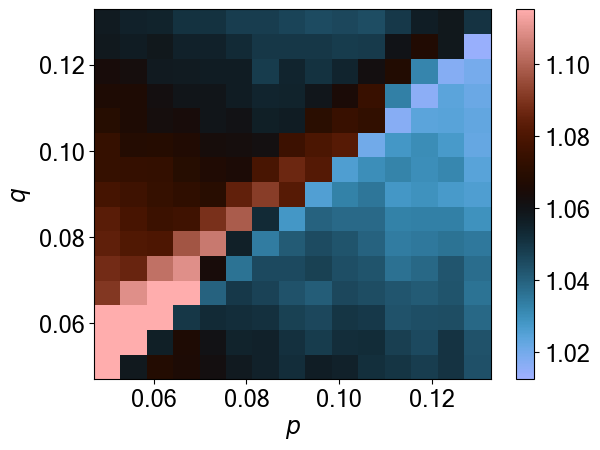

In [ ]:
import matplotlib.pyplot as plt
from matplotlib import cm
from scipy import *
import matplotlib

matplotlib.rcParams.update({'font.size': 17})
plt.rcParams["font.family"] = "Microsoft Sans Serif"   

fig, ax = plt.subplots()

X, Y    = np.meshgrid(prange_data, prange_ancilla)
Z       = np.array(improvement_factor)

# 1.1152711081196527: max value found for 10**(-3) std
# 1.012510355791058: min value found for 10**(-3) std

plt.pcolormesh(X, Y, Z,vmin=1.012510355791058, vmax=1.1152711081196527 , cmap=cm.berlin,linewidth=0, antialiased=False,snap=False)#,shading='gouraud'


plt.colorbar()
plt.xlabel("$p$")
plt.ylabel("$q$")

#Uncomment to save figure
# fig.savefig("Improvement_factor_d_5_r_5_N_5_10__6__5_10_minus_3.pdf",bbox_inches='tight')
